#**Final Report**: Predicting Total Gross Loss: Harnessing Data Analytics Across Time, Region, Basel Categories, and Risk Types
Team B

##Loading Dataset

In [ ]:
#importd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Copy of COO event full as of 9 30 2022.xlsx to Copy of COO event full as of 9 30 2022.xlsx


In [ ]:
import pandas as pd
# Specify the path to your Excel file
excel_file_path = '/content/COO.xlsx'

# Read the Excel file into a DataFrame
data1 = pd.read_excel(excel_file_path)

In [ ]:
data1.shape

(1805, 96)

In [ ]:
column_list = ['Event ID', 'Event Create Date', 'Risk Type (Legacy + From Risk Event)', 'Country', 'Basel 1 Category', 'Basel 2 Category', 'Total Gross Loss']

df_new=data1[column_list].copy()

In [ ]:
df_lgbm = df_new #Make a copy of the dataset for LGBM

In [ ]:
rename = {'Event ID':'id', 'Event Create Date':'date', 'Risk Type (Legacy + From Risk Event)':'type', 'Country':'country', 'Basel 1 Category':'bc1', 'Basel 2 Category':'bc2', 'Total Gross Loss': 'g_loss'}
df_new=df_new.rename(columns=rename).dropna()
df_new.head(2)

In [ ]:
df_new.shape

(1619, 7)

In [ ]:
# Extracting time-related features from 'Event Create Date'
df_new['year'] = df_new['date'].dt.year
df_new['month'] = df_new['date'].dt.month
df_new['quarter'] = df_new['date'].dt.quarter

In [ ]:
# Use factorize() to automatically map string values to integers
df_new['type_number'] = pd.factorize(df_new['type'])[0] + 1
df_new['country_number'] = pd.factorize(df_new['country'])[0] + 1
df_new['bc1_number'] = pd.factorize(df_new['bc1'])[0] + 1
df_new['bc2_number'] = pd.factorize(df_new['bc2'])[0] + 1

In [ ]:
df_new.head(2)

In [ ]:
df_new['year'].unique()

array([2004, 2010, 2011, 2012, 2013, 2014, 2015, 2005, 2016, 2017, 2018,
       2006, 2019, 2007, 2020, 2021, 2008, 2009, 2022])

In [ ]:
# Specify the year you want to remove
year_to_remove = 2020

# Create a new DataFrame excluding the specified year
df_latest = df_new[df_new['year'] != year_to_remove]

##Exploratory Data Analysis

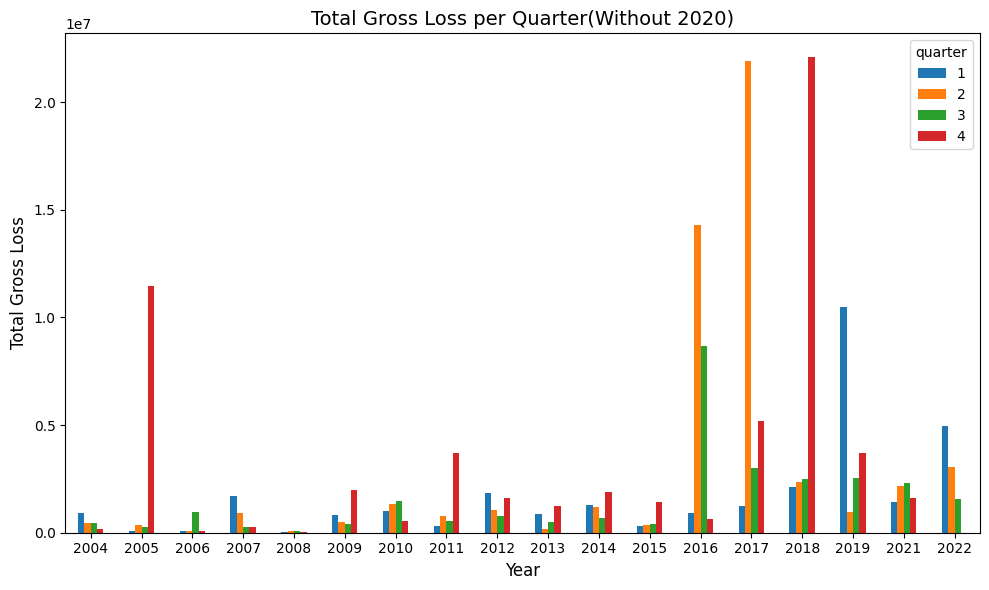

In [ ]:
#Time Series Analysis of the total gross loss per quarter.
#a pivot table to sum the gross losses for each quarter in each year.
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.ticker as mticker
# Creating a pivot table with years and quarters
pivot_gross_loss = df_latest.pivot_table(values='g_loss', index='year', columns='quarter', aggfunc='sum', fill_value=0)

#plot the pivot table data as a bar chart for visualizing the total gross loss per quarter.
fig, ax = plt.subplots(figsize=(10, 6))
pivot_gross_loss.plot(kind='bar', ax=ax)

# Setting the title and labels
ax.set_title('Total Gross Loss per Quarter(Without 2020)', fontsize=14)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Total Gross Loss', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()


Upon a detailed review, it is evident that the financial performance varies seasonally, with a notable trend of increased losses in the final quarter of the year, as it saw elevated losses in 7 out of 18 observed instances.
Such insights are instrumental in fortifying financial strategies and preparing for periodic fluctuations.


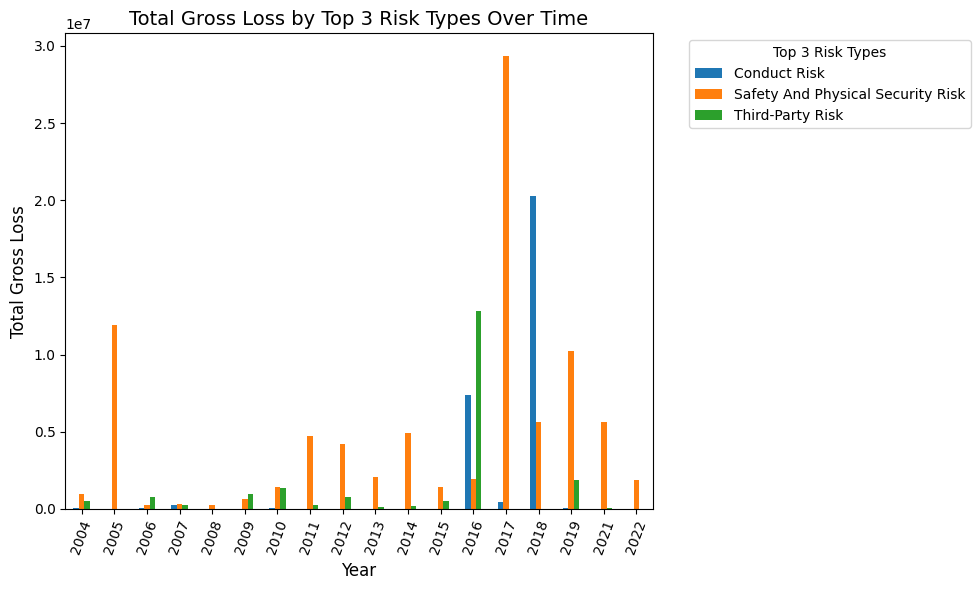

In [ ]:
#Find the top 3 risk types based on total gross loss.
top_risk_types = df_latest.groupby('type')['g_loss'].sum().nlargest(3).index.tolist()

# Filter the dataset to include only the top 3 risk types
top_risk_types_data = df_latest[df_latest['type'].isin(top_risk_types)]

# Aggregate this filtered data by year and the top risk types, summing up the gross losses
top_risk_types_grouped = top_risk_types_data.groupby(['year', 'type'])['g_loss'].sum().reset_index()

# Pivot this data to have years as the index and the top risk types as columns for easy plotting
pivot_top_risk_types = top_risk_types_grouped.pivot(index='year', columns='type', values='g_loss').fillna(0)

#plot the pivot table data as a bar chart for visualizing the total gross loss by top 3 risk types over time.
fig, ax = plt.subplots(figsize=(10, 6))
pivot_top_risk_types.plot(kind='bar', ax=ax)

ax.set_title('Total Gross Loss by Top 3 Risk Types Over Time', fontsize=14)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Total Gross Loss', fontsize=12)
plt.xticks(rotation=70)  # Rotate x-axis labels to show years properly
plt.legend(title='Top 3 Risk Types', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend out of the plot
plt.tight_layout()  # Adjust layout to fit the elements

plt.show()


Throughout the years, Safety and Physical Security Risks have consistently resulted in significant financial impact.
It's imperative that the company fortifies its preventive measures against this persistent risk category to safeguard economic interests and maintain operational continuity.


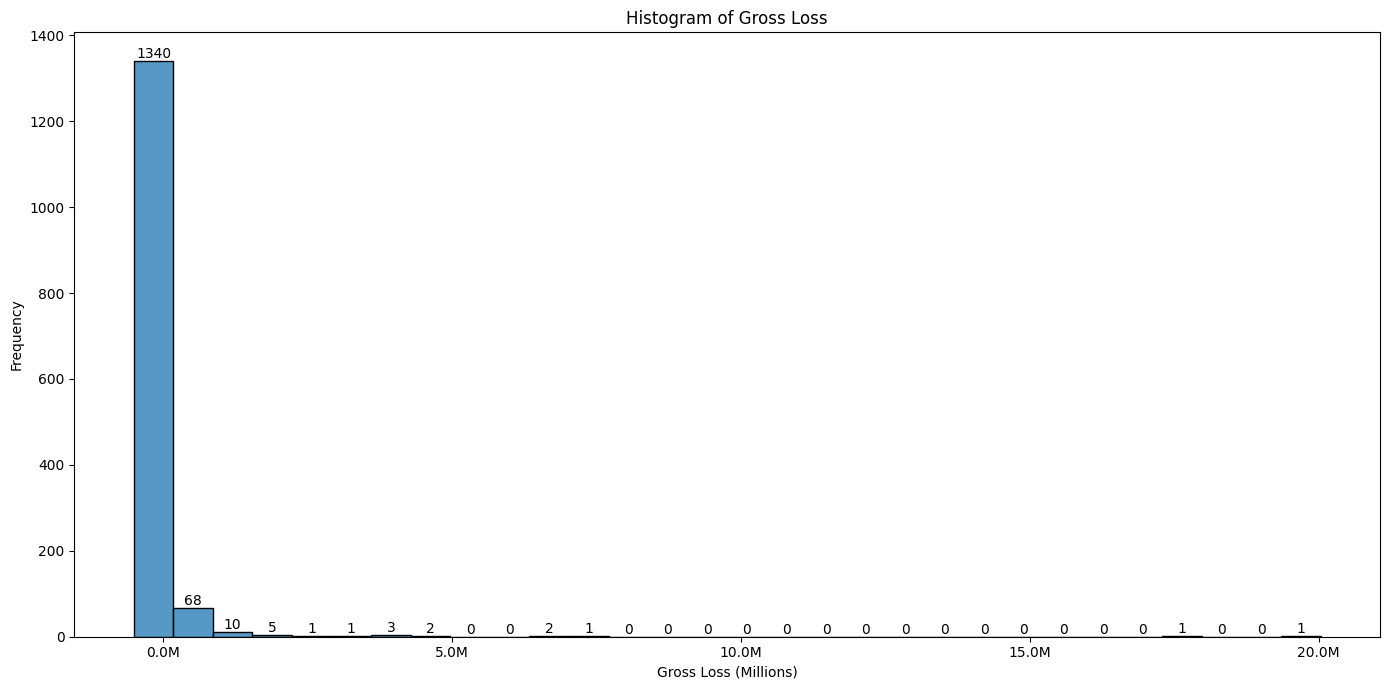

In [ ]:
# Distribution Analysis
# Generate histogram and density plot for Gross Loss
# Set the size of the figure
plt.figure(figsize=(14, 7))

# Create the histogram
ax = sns.histplot(df_latest['g_loss'], bins=30, kde=False, edgecolor='black')

# Format the x-axis tick labels as millions
formatter = mticker.FuncFormatter(lambda x, pos: f'{x*1e-6}M')
ax.xaxis.set_major_formatter(formatter)

# Add the value on top of each bar
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.0f}',
            ha='center', va='bottom', fontsize=10)

plt.title('Histogram of Gross Loss')
plt.xlabel('Gross Loss (Millions)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

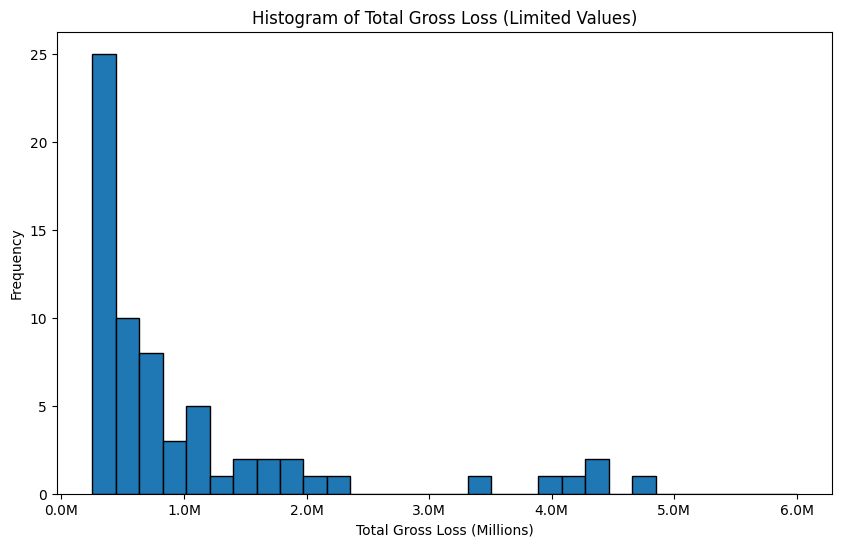

In [ ]:
import matplotlib.pyplot as plt

# Limiting x-axis values (for example, from 0 to 100)
x_min, x_max = 250000, 6000000

plt.figure(figsize=(10, 6))
plt.hist(df_latest['g_loss'], range=(x_min, x_max), bins=30, edgecolor='black')

# Set the title and labels with units in millions
plt.title('Histogram of Total Gross Loss (Limited Values)')
plt.xlabel('Total Gross Loss (Millions)')
plt.ylabel('Frequency')

# Create a formatter function that converts the tick labels to millions
formatter = mticker.FuncFormatter(lambda x, pos: f'{x*1e-6}M')

# Apply the formatter to the x-axis
plt.gca().xaxis.set_major_formatter(formatter)

Our analysis reveals a highly skewed Gross Loss distribution, indicating the tail risks that, while infrequent, pose significant financial threats. This necessitates:
Enhanced provisions in our risk management for potential catastrophic losses.
Adoption of predictive analytics for early detection and mitigation of high-risk scenarios.


##Splitting the dataset

In [ ]:
# Specify the year for testing
test_threshold_year = 2021

# Create a new DataFrame for training and testing
df_train = filtered_df2[filtered_df2['year'] < test_threshold_year]
df_test = filtered_df2[filtered_df2['year'] >= test_threshold_year]

In [ ]:
test1 =filtered_df2

In [ ]:
df_train.shape

(789, 14)

In [ ]:
df_test.shape

(221, 14)

In [ ]:
y_train=df_train[['g_loss']].copy()
X_train=df_train[['year', 'month', 'quarter', 'type_number', 'country_number', 'bc1_number', 'bc2_number']].copy()

y_test=df_test[['g_loss']].copy()
X_test=df_test[['year', 'month', 'quarter', 'type_number', 'country_number', 'bc1_number', 'bc2_number']].copy()

##LightGBM Model

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm.callback import early_stopping

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# This is commented out to save time for ppl working on the file. The later variable "best_params" is the result for running this disabled part. Running this part of code takes hours to get the result. ?
"""
dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)

param_grid = {
    'num_leaves': [15, 20, 25],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.005, 0.01, 0.02],
    'n_estimators': [100, 200, 300],
    'min_child_samples': [30, 40, 50],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'lambda_l1': [0, 0.1, 0.5],
    'lambda_l2': [0, 0.1, 0.5]
}

gbm = lgb.LGBMRegressor(random_state=42)
gridsearch = GridSearchCV(gbm, param_grid, scoring='neg_mean_squared_error', cv=3)
gridsearch.fit(X_train, y_train)

best_params = gridsearch.best_params_
print("Best parameters found by grid search:", best_params)

gbm = lgb.LGBMRegressor(**best_params)
gbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='l2',
    callbacks=[early_stopping(stopping_rounds=10)],
)
"""

In [ ]:
best_params = {
    'colsample_bytree': 0.7,
    'lambda_l1': 0,
    'lambda_l2': 0.5,
    'learning_rate': 0.02,
    'max_depth': 7,
    'min_child_samples': 30,
    'n_estimators': 200,
    'num_leaves': 15,
    'subsample': 0.7
}

gbm = lgb.LGBMRegressor(**best_params, random_state=42)
gbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='l2',
    callbacks=[early_stopping(stopping_rounds=10)]
)

In [ ]:
y_pred = gbm.predict(X_test)

test_rmse = mean_squared_error(y_test, y_pred, squared=False)
test_r2 = r2_score(y_test, y_pred)

print("Test RMSE:", test_rmse)
print("Test R squared:", test_r2)


[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
Test RMSE: 91295.78871155524
Test R squared: -2.8140583457054666


<ipython-input-57-3976b054f874>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='#012169')


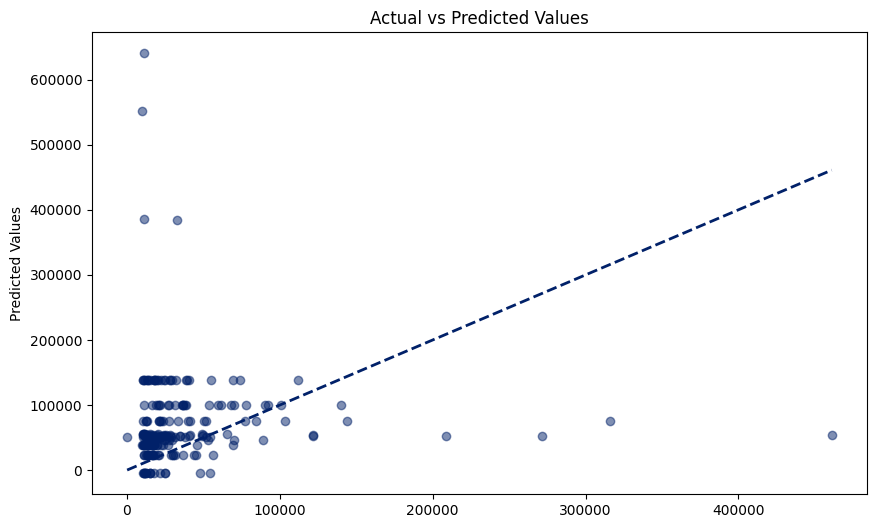

In [ ]:
#graph
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='#012169', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='#012169')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [ ]:
#outlier
test1_unique = test1.drop_duplicates(subset=['year', 'month', 'quarter', 'country_number', 'bc1_number', 'bc2_number'])

matched_X_test = pd.merge(X_test, test1_unique[['id', 'year', 'month', 'quarter', 'country_number', 'bc1_number', 'bc2_number']], on=['year', 'month', 'quarter', 'country_number', 'bc1_number', 'bc2_number'], how='left')
data = pd.DataFrame({
    'id': matched_X_test['id'],
    'Actual': y_test.values.flatten(),
    'Predicted': y_pred
})
data['AbsDifference'] = (data['Actual'] - data['Predicted']).abs()


"\n\n# Perform a merge operation that matches specific columns and adds the 'id' from 'test1' to 'X_test'\nmatched_X_test = pd.merge(X_test, test1[['id', 'year', 'month', 'quarter', 'country_number', 'bc1_number', 'bc2_number']], on=['year', 'month', 'quarter', 'country_number', 'bc1_number', 'bc2_number'], how='inner')\n\n# Make sure the lengths of matched_X_test and y_test are the same\nmatched_X_test = matched_X_test.head(len(y_test))\n\n# Create the 'data' DataFrame with the 'id', 'Actual', and 'Predicted' values\ndata = pd.DataFrame({\n    'id': matched_X_test['id'],\n    'Actual': y_test.values.flatten(),\n    'Predicted': y_pred\n})\n\n# Calculate the absolute differences\ndata['AbsDifference'] = (data['Actual'] - data['Predicted']).abs()\n\ndata = pd.DataFrame({\n    'Actual': y_test.values.flatten(),\n    'Predicted': y_pred\n})\n\ndata['AbsDifference'] = (data['Actual'] - data['Predicted']).abs()\n\nsorted_data = data.sort_values(by='AbsDifference', ascending=False)\n\n\ntop_

In [ ]:
data

,id,Actual,Predicted,AbsDifference
0,GLA-6081854,69102.0,138204.207436,69102.207436
1,GLA-6081854,40384.0,138204.207436,97820.207436
2,GLA-6081854,18332.0,138204.207436,119872.207436
3,GLA-6081854,29244.0,138204.207436,108960.207436
4,GLA-6081854,25168.0,138204.207436,113036.207436
...,...,...,...,...
216,ORE-6230102,17759.0,50467.574044,32708.574044
217,ORE-6231959,53392.0,100399.913496,47007.913496
218,ORE-6231959,18748.0,100399.913496,81651.913496
219,ORE-6231959,21043.0,100399.913496,79356.913496


In [ ]:
sorted_data = data.sort_values(by='AbsDifference', ascending=False)
top_eight_abs_difference = sorted_data.head(8)

In [ ]:
top_eight_abs_difference

In [ ]:
matched_rows_in_data1 = data1[data1['Event ID'].isin(top_eight_abs_difference['id'])]
cleaned_matched_rows = matched_rows_in_data1.dropna(axis=1)
cleaned_matched_rows

The insights gleaned from our analysis on these eight outliers pinpoint four crucial areas: prioritizing Safety and Physical Security, strengthening governance for natural disaster response, improving oversight of third-party relationships, and fortifying overall business resilience. Additionally, placing emphasis on proactive initiatives to preserve customer satisfaction is vital for cultivating trust and securing sustained success.

In [ ]:
cleaned_matched_rows.columns

In [ ]:
"""
#write to file
cleaned_matched_rows.to_excel("output.xlsx", index=False)
from google.colab import files
files.download('output.xlsx')
"""

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

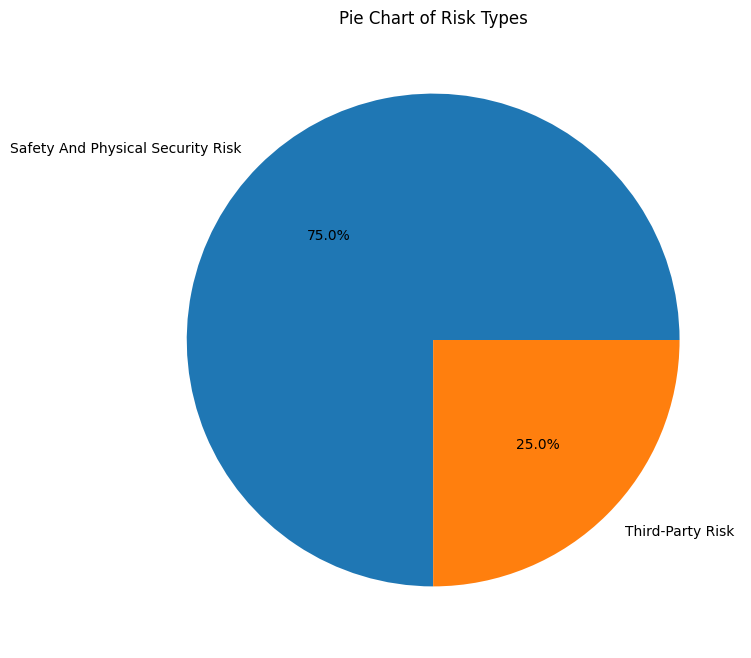

In [ ]:
#graphs for outliers
risk_type_counts = cleaned_matched_rows['Risk Type (Legacy + From Risk Event)'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(risk_type_counts, labels=risk_type_counts.index, autopct='%1.1f%%')
plt.title('Risk Types of significant outlier')
plt.show()

In [ ]:
y_test_array = y_test.values.ravel()

# Calculating the MAPE for the LightGBM model
mape_lgb = compute_mape(y_test_array, y_pred)
print("Test MAPE (LightGBM):", mape_lgb)

Test MAPE (LightGBM): 1297.9578273589073


**Major insights:**

1. Limited predictive power of time factors
2. Importance of Basel Categories in Risk Management (SHAP analysis)
3. Key Areas of Focus for Risk Mitigitation, recommendations for future resource alloction.
4. Proactive Initiatives for Customer Satisfaction


## SHAP VALUE - Light GBM

In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 8.9 MB/s eta 0:00:00


In [ ]:
import shap

In [ ]:
# Combining train and test datasets
combined_df = pd.concat([df_train, df_test])
# Splitting into X(features) and y(target)
X = combined_df[['year', 'month', 'quarter', 'country_number', 'bc1_number', 'bc2_number']]
y = combined_df['g_loss']

In [ ]:
# Create a SHAP explainer for the LightGBM model
explainer = shap.TreeExplainer(gbm)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X)

In [ ]:
# Choose the first instance from test data
instance_idx = 0

# Visualize SHAP values for that instance
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[instance_idx], X_test.iloc[instance_idx, :])

The following image is a force plot for one prediction. The **base value** we can see is around 1.192e+5. The predicted value is 281,610.

Each **red bar** shows a feature that contributes to increasing the prediction value. The length of the bar indicates the magnitude of the feature's contribution. In this case, bc2_number which is encoded by basel category. and 2 is 'Disaster and other events' in our dataset and year 2021 are pushing the prediction higher. And the feature year 2021 contributes a lot.

Each **blue bar** represents a feature that contributes to decreasing the prediction value. So month = 1 and bc1_number = 2 which is Damage to Physical Assets risk type are pushing the prediction lower.


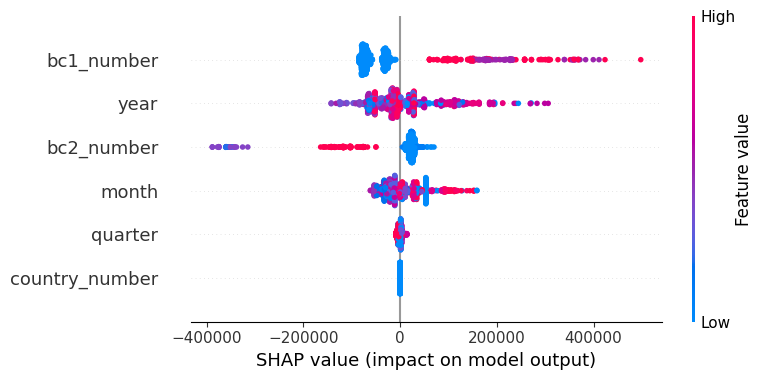

In [ ]:
# SHAP Summary Plot
shap.summary_plot(shap_values, X)

Risk categories '**bc1_number**' and '**bc2_number**' are major influencers,  some types of risk strongly associated with gross loss.

Temporal factors like '**year**', '**month**', and '**quarter**' show varying degrees of impact.

In [ ]:
# See Basel Categories with corresponding number
mapping_bc1 = dict(zip(df_new['bc1_number'], df_new['bc1']))
mapping_bc2 = dict(zip(df_new['bc2_number'], df_new['bc2']))

In [ ]:
# Using the existing mapping_bc1 dictionary
bc1_with_numbers = [(number, bc1) for number, bc1 in mapping_bc1.items()]
bc1_with_numbers

In [ ]:
# Using the existing mapping_bc2 dictionary
bc2_with_numbers = [(number, bc2) for number, bc2 in mapping_bc2.items()]
bc2_with_numbers

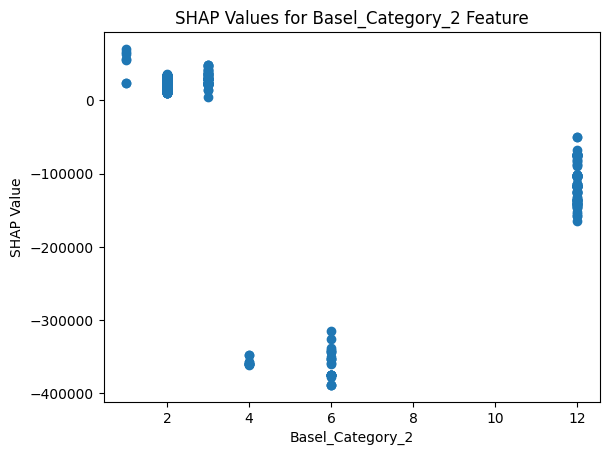

In [ ]:
# Extract SHAP values for the 'bc2_number' feature
bc2_shap_values = shap_values[:, X.columns.get_loc('bc2_number')]

# Create the scatter plot
plt.scatter(X['bc2_number'], bc2_shap_values)
plt.xlabel('Basel_Category_2')
plt.ylabel('SHAP Value')
plt.title('SHAP Values for Basel_Category_2 Feature')

plt.show()

bc2_number (6, '**Improper Business or Market Practices**'),(12, '**Safe Environment**') associated with lower gross losses

bc2_number (2, '**Disaster and other events**')and (3, '**Vendors & Suppliers**') are strongly associated with higher gross losses

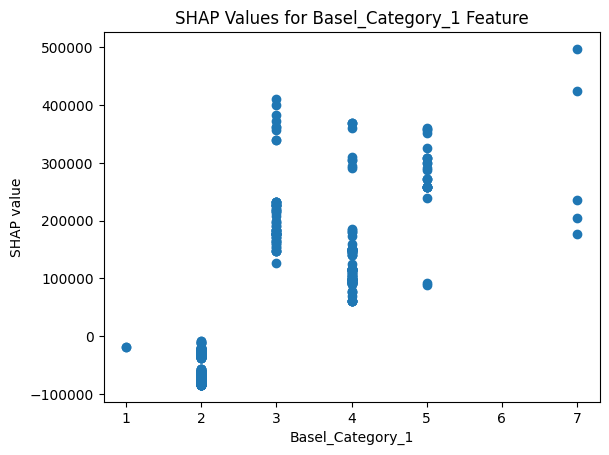

In [ ]:
# Extract SHAP values for the 'bc1_number' feature
bc1_shap_values = shap_values[:, X.columns.get_loc('bc1_number')]

# Create the scatter plot
plt.scatter(X['bc1_number'], bc1_shap_values)
plt.xlabel('Basel_Category_1')
plt.ylabel('SHAP Value')
plt.title('SHAP Values for Basel_Category_1 Feature')
plt.show()

bc1_number (3, '**Execution, Delivery & Process Management**'), (4, '**Employment Practices and Workplace Safety**'), (5, '**Clients, Products & Business Practices**') are associated with a strong influence on increasing the likelihood or magnitude of operational losses.

bc1_number (2, '**Damage to Physical Assets**') is associated with lower gross losses.